CSC 180
Mini-Project 1
Yelp Business Rating Prediction Using Tensorflow


Warren Quattrocchi
Janus Kwan
Andrew Wright




Imports and Tensor flow helper functions

In [1]:
import collections
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import numpy as np
import pandas as pd
import shutil
import csv
import json
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low


Load reviews.json into a tsv file

In [4]:
outfile = open ("reviews.tsv", 'w')
sfile = csv.writer(outfile, delimiter = "\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars','text','useful','funny','cool'])

with open('review.json', encoding='utf-8') as f:
    for line in f:
        row = json.loads(line)
        sfile.writerow([row['business_id'],row['stars'], (row['text']).encode('utf-8'),row['useful'],row['funny'],row['cool']])
        
outfile.close()


In [5]:
df = pd.read_csv('reviews.tsv',delimiter="\t", encoding = "utf-8")
df.head()

,business_id,stars,text,useful,funny,cool
0,ujmEBvifdJM6h6RLv4wQIg,1.0,b'Total bill for this horrible service? Over $...,6,1,0
1,NZnhc2sEQy3RmzKTZnqtwQ,5.0,"b""I *adore* Travis at the Hard Rock's new Kell...",0,0,0
2,WTqjgwHlXbSFevF32_DJVw,5.0,"b""I have to say that this office really has it...",3,0,0
3,ikCg8xy5JIg_NGPx-MSIDA,5.0,"b""Went in for a lunch. Steak sandwich was deli...",0,0,0
4,b1b1eb3uo-w561D0ZfCEiQ,1.0,b'Today was my second out of three sessions I ...,7,0,0


Load business.json into a tsv file

In [7]:
outfile2 = open("business.tsv", 'w')
sfile = csv.writer(outfile2,delimiter = "\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id', 'review_count', 'name','stars','categories'])

with open('business.json', encoding='utf-8') as f:
    for line in f:
        row = json.loads(line)
        sfile.writerow([row['business_id'], row['review_count'], (row['name']).encode('utf-8'), row['stars'],row['categories']])
        
outfile2.close()


In [8]:
df2 = pd.read_csv('business.tsv', delimiter="\t", encoding = "utf-8")
df2.head()


,business_id,review_count,name,stars,categories
0,1SWheh84yJXfytovILXOAQ,5,b'Arizona Biltmore Golf Club',3.0,"Golf, Active Life"
1,QXAEGFB4oINsVuTFxEYKFQ,128,b'Emerald Chinese Restaurant',2.5,"Specialty Food, Restaurants, Dim Sum, Imported..."
2,gnKjwL_1w79qoiV3IC_xQQ,170,b'Musashi Japanese Restaurant',4.0,"Sushi Bars, Restaurants, Japanese"
3,xvX2CttrVhyG2z1dFg_0xw,3,b'Farmers Insurance - Paul Lorenz',5.0,"Insurance, Financial Services"
4,HhyxOkGAM07SRYtlQ4wMFQ,4,b'Queen City Plumbing',4.0,"Plumbing, Shopping, Local Services, Home Servi..."


Group all reviews by business ID, sum up useful, funny, and cool votes for each business

In [9]:
df_review_agg=df.groupby('business_id').agg({'useful': np.sum, 'funny': np.sum, 'cool': np.sum, 'text':np.sum})
df_ready_for_sklearn = pd.DataFrame({'business_id':df_review_agg.index,'all_reviews': df_review_agg['text'], 'all_useful': df_review_agg['useful'],'all_funny': df_review_agg['funny'],'all_cool': df_review_agg['cool'] })
df_ready_for_sklearn.drop('business_id', axis=1, inplace=True)

In [10]:
df_ready_for_sklearn.head()

,all_reviews,all_useful,all_funny,all_cool
business_id,,,,
--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,17,1,16
--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si...",61,30,35
--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",86,30,65
--8LPVSo5i0Oo61X01sV9A,b'Dr. LaCognata is great. He is a great liste...,11,0,0
--9QQLMTbFzLJ_oT-ON3Xw,b'Always great customer service. Affordable ha...,8,3,4


Change vote columns to z scores for training

In [11]:
encode_numeric_zscore(df_ready_for_sklearn , 'all_useful')
encode_numeric_zscore(df_ready_for_sklearn , 'all_funny')
encode_numeric_zscore(df_ready_for_sklearn , 'all_cool')


In [12]:
df_ready_for_sklearn.head()

,all_reviews,all_useful,all_funny,all_cool
business_id,,,,
--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,-0.164351,-0.136213,-0.046024
--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si...",0.076650,0.114461,0.167739
--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",0.213583,0.114461,0.505261
--8LPVSo5i0Oo61X01sV9A,b'Dr. LaCognata is great. He is a great liste...,-0.197215,-0.144857,-0.226036
--9QQLMTbFzLJ_oT-ON3Xw,b'Always great customer service. Affordable ha...,-0.213647,-0.118925,-0.181033


merge business and review tables together on business_id

In [13]:
review_and_business_df =pd.merge(df_ready_for_sklearn,df2, on='business_id')


In [14]:
review_and_business_df.head()

,business_id,all_reviews,all_useful,all_funny,all_cool,review_count,name,stars,categories
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,-0.164351,-0.136213,-0.046024,24,b'The Spicy Amigos',4.0,"Restaurants, Mexican"
1,--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si...",0.076650,0.114461,0.167739,44,"b""John's Chinese BBQ Restaurant""",3.0,"Chinese, Restaurants"
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",0.213583,0.114461,0.505261,58,b'Primal Brewery',4.0,"Breweries, Food"
3,--8LPVSo5i0Oo61X01sV9A,b'Dr. LaCognata is great. He is a great liste...,-0.197215,-0.144857,-0.226036,4,b'Valley Bone and Joint Specialists',3.5,"Orthopedists, Doctors, Sports Medicine, Weight..."
4,--9QQLMTbFzLJ_oT-ON3Xw,b'Always great customer service. Affordable ha...,-0.213647,-0.118925,-0.181033,12,b'Great Clips',3.5,"Beauty & Spas, Hair Salons"


drop all businesses with less than 20 reviews

In [15]:
review_and_business_df = review_and_business_df[review_and_business_df.review_count > 20]
review_and_business_df.drop('review_count', axis=1, inplace=True)


save current dataframe and load it

In [16]:
review_and_business_df.to_csv ("./reviewCombined.csv", index = False)


In [17]:
review_and_business_df = pd.read_csv("./reviewCombined.csv",na_values=['NA','?'])


create a tf-idf vector to use only the most commonly used categories

In [18]:
tfidf_vectorizer_cat=TfidfVectorizer(min_df = .01,  max_features = 100)
tfidf_vectorizer_vectors_cat=tfidf_vectorizer_cat.fit_transform(review_and_business_df['categories'].values.astype('U'))

tfidf_vectorizer_cat.get_feature_names()

['active',
 'american',
 'arts',
 'asian',
 'auto',
 'automotive',
 'bakeries',
 'barbeque',
 'bars',
 'beauty',
 'beer',
 'breakfast',
 'brunch',
 'burgers',
 'cafes',
 'canadian',
 'car',
 'care',
 'caterers',
 'centers',
 'chicken',
 'chinese',
 'cocktail',
 'coffee',
 'cream',
 'day',
 'delis',
 'dentists',
 'desserts',
 'diners',
 'doctors',
 'entertainment',
 'estate',
 'event',
 'fashion',
 'fast',
 'fitness',
 'food',
 'frozen',
 'fusion',
 'garden',
 'grocery',
 'hair',
 'health',
 'home',
 'hotels',
 'ice',
 'instruction',
 'italian',
 'japanese',
 'juice',
 'life',
 'local',
 'lounges',
 'massage',
 'medical',
 'mediterranean',
 'mexican',
 'music',
 'nail',
 'new',
 'nightlife',
 'pet',
 'pets',
 'pizza',
 'planning',
 'pubs',
 'real',
 'removal',
 'repair',
 'restaurants',
 'salad',
 'salons',
 'sandwiches',
 'seafood',
 'service',
 'services',
 'shopping',
 'shops',
 'skin',
 'smoothies',
 'spaces',
 'spas',
 'specialty',
 'spirits',
 'sports',
 'stations',
 'steakhouses'

In [19]:
tfidf_vectorizer_vectors_cat

<55597x100 sparse matrix of type '<class 'numpy.float64'>'
	with 253218 stored elements in Compressed Sparse Row format>

create a tf-idf vector to get the most important words used in all reviews

In [20]:
tfidf_vectorizer=TfidfVectorizer(stop_words ='english',min_df = 5, max_features = 500)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(review_and_business_df['all_reviews'])

In [21]:
tfidf_vectorizer.get_feature_names()

['10',
 '15',
 '20',
 '30',
 '50',
 'able',
 'absolutely',
 'actually',
 'add',
 'ago',
 'amazing',
 'appetizer',
 'appointment',
 'area',
 'arrived',
 'ask',
 'asked',
 'ate',
 'atmosphere',
 'attentive',
 'authentic',
 'available',
 'average',
 'away',
 'awesome',
 'bacon',
 'bad',
 'bar',
 'bbq',
 'beautiful',
 'beef',
 'beer',
 'believe',
 'best',
 'better',
 'big',
 'birthday',
 'bit',
 'bite',
 'bowl',
 'bread',
 'breakfast',
 'bring',
 'brought',
 'brunch',
 'buffet',
 'burger',
 'burgers',
 'business',
 'busy',
 'butter',
 'buy',
 'cake',
 'called',
 'came',
 'car',
 'card',
 'care',
 'change',
 'charge',
 'cheap',
 'check',
 'cheese',
 'chef',
 'chicken',
 'chinese',
 'chips',
 'chocolate',
 'choice',
 'choose',
 'city',
 'clean',
 'close',
 'club',
 'coffee',
 'cold',
 'come',
 'comes',
 'comfortable',
 'coming',
 'company',
 'completely',
 'cooked',
 'cool',
 'cost',
 'couldn',
 'counter',
 'couple',
 'course',
 'crab',
 'cream',
 'crispy',
 'customer',
 'customers',
 'cut',

drop all columns not needed for training

In [22]:

review_and_business_df.drop('name', axis=1, inplace=True)
review_and_business_df.drop('business_id', axis=1, inplace=True)
review_and_business_df.drop('all_reviews',axis=1,inplace=True)
review_and_business_df.drop('categories',axis=1, inplace=True)

trasnform the tf-idf vectors to numpy arrays

In [23]:
reviews_idf =tfidf_vectorizer_vectors.toarray()
cat_idf =tfidf_vectorizer_vectors_cat.toarray()


transform numpy arrays into dataframes to concat together

In [24]:
reviews_idf_df = pd.DataFrame(reviews_idf, columns=tfidf_vectorizer.get_feature_names())
cat_idf_df = pd.DataFrame(cat_idf, columns=tfidf_vectorizer_cat.get_feature_names())

In [25]:
reviews_idf_df.head()

,10,15,20,30,50,able,absolutely,actually,add,ago,...,worth,wouldn,wow,wrong,xc3,year,years,yelp,yes,yummy
0,0.010259,0.011976,0.000000,0.000000,0.000000,0.000000,0.011479,0.000000,0.000000,0.000000,...,0.021380,0.000000,0.014535,0.011852,0.016307,0.000000,0.010881,0.000000,0.000000,0.000000
1,0.015254,0.022259,0.004340,0.026158,0.020430,0.004310,0.000000,0.011810,0.000000,0.017884,...,0.023844,0.026688,0.010807,0.000000,0.000000,0.000000,0.040450,0.014552,0.014268,0.000000
2,0.015952,0.006207,0.000000,0.006079,0.000000,0.012020,0.005950,0.000000,0.007266,0.000000,...,0.011082,0.006202,0.007534,0.006143,0.000000,0.000000,0.000000,0.000000,0.019894,0.000000
3,0.015464,0.007791,0.011855,0.008932,0.013734,0.015638,0.019854,0.015459,0.008230,0.011260,...,0.041049,0.010822,0.015452,0.011848,0.058478,0.016299,0.020373,0.009731,0.017255,0.017154
4,0.030525,0.007127,0.013894,0.020938,0.000000,0.000000,0.006831,0.000000,0.025028,0.014315,...,0.006362,0.007121,0.000000,0.000000,0.009705,0.000000,0.006475,0.000000,0.015227,0.009748


In [26]:
cat_idf_df.head()

,active,american,arts,asian,auto,automotive,bakeries,barbeque,bars,beauty,...,sushi,tea,thai,traditional,travel,venues,waxing,wine,wings,yogurt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


concat business df, category df, and review df

In [27]:
combineddf = pd.concat([review_and_business_df,cat_idf_df,reviews_idf_df],axis=1)



In [28]:
combineddf.head()

,all_useful,all_funny,all_cool,stars,active,american,arts,asian,auto,automotive,...,worth,wouldn,wow,wrong,xc3,year,years,yelp,yes,yummy
0,-0.164351,-0.136213,-0.046024,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021380,0.000000,0.014535,0.011852,0.016307,0.000000,0.010881,0.000000,0.000000,0.000000
1,0.076650,0.114461,0.167739,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023844,0.026688,0.010807,0.000000,0.000000,0.000000,0.040450,0.014552,0.014268,0.000000
2,0.213583,0.114461,0.505261,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011082,0.006202,0.007534,0.006143,0.000000,0.000000,0.000000,0.000000,0.019894,0.000000
3,9.437370,7.781622,13.083565,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.041049,0.010822,0.015452,0.011848,0.058478,0.016299,0.020373,0.009731,0.017255,0.017154
4,-0.158874,-0.118925,-0.113528,3.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006362,0.007121,0.000000,0.000000,0.009705,0.000000,0.006475,0.000000,0.015227,0.009748


save and load df ready for training

In [29]:
combineddf.to_csv ("./testReady.csv", index = False)

In [3]:
combineddf = pd.read_csv("./testReady.csv",na_values=['NA','?'])

In [4]:
x,y = to_xy(combineddf,'stars')


In [5]:
combineddf.head(10)

,all_useful,all_funny,all_cool,stars,active,american,arts,asian,auto,automotive,...,worth,wouldn,wow,wrong,xc3,year,years,yelp,yes,yummy
0,-0.164351,-0.136213,-0.046024,4.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.021380,0.000000,0.014535,0.011852,0.016307,0.000000,0.010881,0.000000,0.000000,0.000000
1,0.076650,0.114461,0.167739,3.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.023844,0.026688,0.010807,0.000000,0.000000,0.000000,0.040450,0.014552,0.014268,0.000000
2,0.213583,0.114461,0.505261,4.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.011082,0.006202,0.007534,0.006143,0.000000,0.000000,0.000000,0.000000,0.019894,0.000000
3,9.437370,7.781622,13.083565,4.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.041049,0.010822,0.015452,0.011848,0.058478,0.016299,0.020373,0.009731,0.017255,0.017154
4,-0.158874,-0.118925,-0.113528,3.5,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.006362,0.007121,0.000000,0.000000,0.009705,0.000000,0.006475,0.000000,0.015227,0.009748
5,0.323129,0.278696,0.527763,4.0,0.0,0.286124,0.0,0.0,0.0,0.000000,...,0.007799,0.005820,0.000000,0.014412,0.007932,0.014695,0.023817,0.006347,0.012446,0.015934
6,-0.054805,0.036666,0.021480,3.5,0.0,0.329596,0.0,0.0,0.0,0.000000,...,0.016497,0.027697,0.005608,0.013718,0.000000,0.009325,0.004198,0.000000,0.004936,0.012639
7,0.032832,0.071241,-0.001021,3.0,0.0,0.000000,0.0,0.0,0.0,0.365772,...,0.042792,0.000000,0.014546,0.023721,0.000000,0.060468,0.087113,0.039175,0.025606,0.000000
8,-0.120533,-0.092993,-0.192284,2.0,0.0,0.340504,0.0,0.0,0.0,0.000000,...,0.027633,0.020620,0.000000,0.030637,0.000000,0.010413,0.046879,0.000000,0.011024,0.000000
9,-0.043850,-0.058417,0.088984,3.5,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.027061,0.012116,0.007359,0.000000,0.016512,0.018355,0.000000,0.013213,0.012954,0.024879


In [6]:
x.shape

(55597, 603)

In [7]:
x.shape[1]

603

In [8]:
y

array([4. , 3. , 4. , ..., 4. , 3. , 3.5], dtype=float32)

Formula to not have too many neurons

In [9]:
n_i = x.shape[1]
n_s = x.shape[0]
n_o = 1
alpha = 2
n_h = ((n_s)/(alpha * (n_i + n_o)))
n_h_temp = n_h
print(n_h)


46.02400662251656


Model using sigmoid

In [10]:
#formula found online to keep from overfitting neurons
n_i = x.shape[1]
n_s = x.shape[0]
n_o = 1
alpha = 2
n_h = ((n_s)/(alpha * (n_i + n_o)))

#variables to quickly change model parameters
model = Sequential()
mode = "sigmoid"
batch = 64
epo = 400
n_h = round(n_h)
if (n_h % 2) != 0:
    n_h = n_h - 1
    
model.add(Dense(n_h,input_dim=x.shape[1],activation=mode))   
model.add(Dense(n_h/8,input_dim=x.shape[1],activation=mode))   
model.add(Dense(n_o))

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.20, random_state = 42)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss="mean_squared_error",optimizer =  adam)
monitor = EarlyStopping(monitor='val_loss', min_delta =1e-5, patience=5, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath="./best_weights.hdf5", verbose=0, save_best_only=True) # save best model
model.fit(x_train,y_train,validation_data = (x_test,y_test),batch_size = batch,callbacks = [monitor,checkpointer],verbose=2,epochs=epo)


W0926 20:23:02.902335 18012 deprecation.py:506] From D:\anaconda\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 44477 samples, validate on 11120 samples
Epoch 1/400
44477/44477 - 1s - loss: 2.1936 - val_loss: 0.6817
Epoch 2/400
44477/44477 - 1s - loss: 0.6297 - val_loss: 0.6282
Epoch 3/400
44477/44477 - 1s - loss: 0.6186 - val_loss: 0.6245
Epoch 4/400
44477/44477 - 1s - loss: 0.5257 - val_loss: 0.2589
Epoch 5/400
44477/44477 - 1s - loss: 0.1530 - val_loss: 0.1079
Epoch 6/400
44477/44477 - 1s - loss: 0.0987 - val_loss: 0.0899
Epoch 7/400
44477/44477 - 1s - loss: 0.0865 - val_loss: 0.0813
Epoch 8/400
44477/44477 - 1s - loss: 0.0791 - val_loss: 0.0769
Epoch 9/400
44477/44477 - 1s - loss: 0.0751 - val_loss: 0.0754
Epoch 10/400
44477/44477 - 1s - loss: 0.0729 - val_loss: 0.0728
Epoch 11/400
44477/44477 - 1s - loss: 0.0715 - val_loss: 0.0719
Epoch 12/400
44477/44477 - 1s - loss: 0.0702 - val_loss: 0.0729
Epoch 13/400
44477/44477 - 1s - loss: 0.0695 - val_loss: 0.0709
Epoch 14/400
44477/44477 - 1s - loss: 0.0687 - val_loss: 0.0726
Epoch 15/400
44477/44477 - 1s - loss: 0.0680 - val_loss: 0.0699

In [11]:
model.load_weights('./best_weights.hdf5') # load weights from best model


In [12]:
pred=model.predict(x_test)

score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

score=np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score: (RSME): {}".format(score))

Final score (MSE): 0.06519310921430588
Score: (RSME): 0.2553294003009796


In [13]:
df_y = pd.DataFrame(y_test, columns= ['ground_truth'])
df_pred = pd.DataFrame(pred, columns = ["predicted"])
result = pd.concat([df_y,df_pred], axis=1)
result.head()

,ground_truth,predicted
0,3.5,3.509006
1,2.5,2.525843
2,3.0,3.131686
3,4.0,3.843793
4,3.5,3.217943


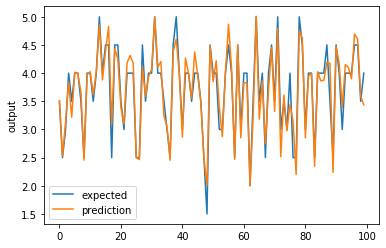

In [14]:
chart_regression(pred[:100].flatten(),y_test[:100],sort=False)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 46)                27784     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 235       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 28,025
Trainable params: 28,025
Non-trainable params: 0
_________________________________________________________________
